In [8]:
import pandas as pd
from PlateAnalyzer import *

## Load your analysis file here. It is recommended to export the 
## raw data with no background subraction for optimal results. 
user_file_name = 'rpo b EXP.xlsx'

In [9]:
## Analyzes excel file, generate csv files and plots
file_name = user_file_name.split("\\")[-1]
pa = PlateAnalyzer(filename=file_name)
params_df, qoi_df, data_dict = pa.analyze()

# Generates PDF of all curves in plate 
data_keys = list(data_dict.keys())    
plot_vars = make_plots(data_dict, file_name)

# export qoi and params_df files to csv for further processing
qoi_df.to_csv(file_name[:-5] + '_qoi.csv')
params_df.to_csv(file_name[:-5] + '_params.csv')

PermissionError: [Errno 13] Permission denied: 'rpo b EXP.xlsx'

In [3]:
params_df.head()

,F_max,C_half,k,F_b,DriftSlope,Fluorophore
A1,83.524452,143.234014,0.518029,5924.116937,25.792511,FAM
A2,69.405187,143.533641,1.364417,5864.904467,28.099849,FAM
A3,0.040005,143.522575,1.315683,6150.211908,28.607526,FAM
A4,16841.038735,83.049987,1.885564,5520.493375,36.356583,FAM
A5,19515.903909,58.326092,3.326717,5819.995155,13.998473,FAM


In [4]:
qoi_df.head()

,F_0,F_1,F_2,F_max,deltaF,R2_score,C_half,dFdC_half,C_lift,C_slow,deltaC,Fluorophore
A1,5924.116937,NaN,NaN,9018.960332,3094.843394,0.992182,143.234014,46.673624,NaN,NaN,NaN,FAM
A2,5864.904467,9236.605406,5864.904467,9236.605406,3371.700939,0.994090,143.533641,45.451146,119.99,0.00,-119.99,FAM
A3,6150.211908,9582.828962,6150.211908,9582.828962,3432.617054,0.991779,143.522575,28.617527,119.99,0.00,-119.99,FAM
A4,5520.493375,12013.471556,21907.421832,26723.958476,21203.465101,0.998488,83.049987,4246.616267,80.57,85.53,4.96,FAM
A5,5819.995629,10694.435542,22092.246698,27015.575716,21195.580086,0.997742,58.326092,4892.974451,53.94,62.71,8.77,FAM


In [5]:
# This is what a reasonable well looks like:
qoi_df.loc['B3']

,F_0,F_1,F_2,F_max,deltaF,R2_score,C_half,dFdC_half,C_lift,C_slow,deltaC,Fluorophore
B3,4518.696270,7377.812474,4518.696270,7377.812474,2859.116204,0.989140,1.417602e+02,31.023017,119.99,0.00,-119.99,FAM
B3,2349.040600,2407.422525,2497.237088,2610.747025,261.706425,0.998519,4.341572e+01,19.008686,28.05,58.78,30.73,HEX
B3,1812.571565,1812.625608,1825.158463,1825.158463,12.586897,0.789681,1.440000e+02,4.070809,119.99,0.00,-119.99,Texas Red
B3,1740.216502,1742.574109,1740.216502,1743.327218,3.110716,0.155668,4.206951e-10,40.634602,0.00,119.99,119.99,Cy5
B3,1822.061593,1831.602015,1822.061593,1831.602015,9.540422,0.626850,8.983244e+01,80.061666,0.00,119.99,119.99,Quasar 705


In [6]:
# This is what a reasonable well looks like:
params_df.loc['B3']

,F_max,C_half,k,F_b,DriftSlope,Fluorophore
B3,28.780250,1.417602e+02,0.907389,4518.696270,23.827954,FAM
B3,69.571598,4.341572e+01,11.669234,2347.395345,1.615787,HEX
B3,16.781964,1.440000e+02,13.512328,1825.158068,-0.124682,Texas Red
B3,164.085728,4.206951e-10,100.000000,1660.531245,-0.386830,Cy5
B3,323.644304,8.983244e+01,99.998052,1737.942150,-0.849410,Quasar 705


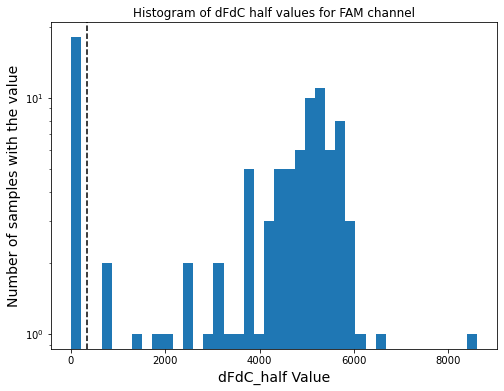

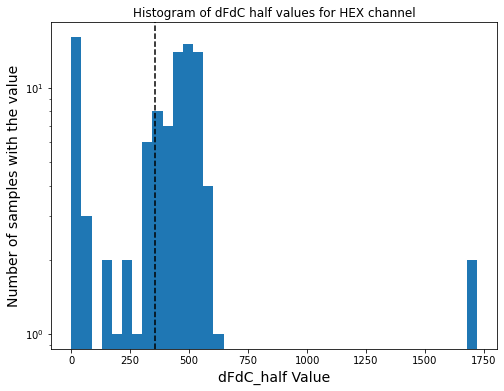

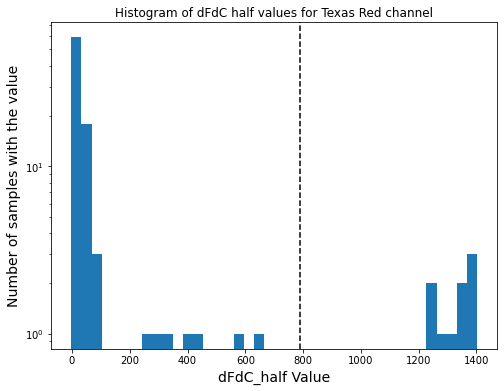

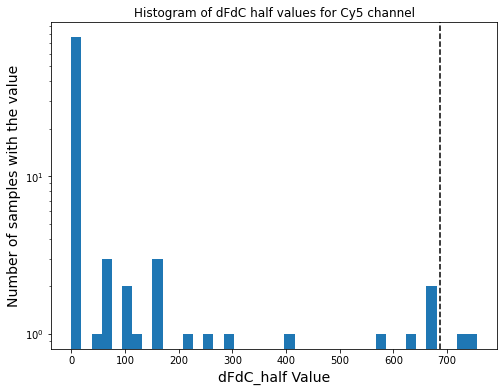

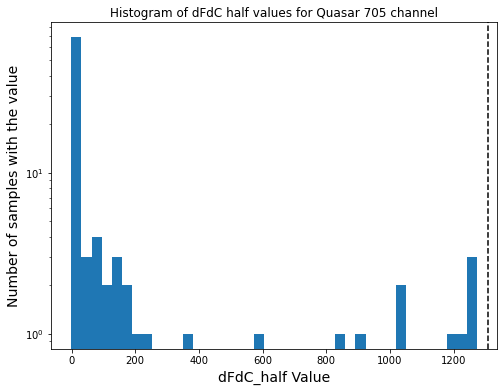

In [7]:
# Consider binning by the analytical dFdC_half, which is computed as a low value for the 'bad' cells
# Look at it graphically with this plot! This is using dF/dC_half for known negative and positive 
# amplification wells. 

import matplotlib.pyplot as plt

# Insert known positive wells here. This assumes that it applies across all fluorophores, which is 
# not always true. In that case, a dataframe will be required to insert well values. 
negative_wells = ['A1', 'A2', 'A3']
positive_wells = ['A5', 'A6', 'A7']

# Creates negative (zero) and positive (amp) dataframes for the identified control wells. 
zero_df = qoi_df[qoi_df.index.isin(negative_wells)]
amp_df = qoi_df[qoi_df.index.isin(positive_wells)]

for each in qoi_df.Fluorophore.unique():
    #temp_zero = zero_df[zero_df['Fluorophore'] == each]
    avg_negatives = int(zero_df[zero_df['Fluorophore'] == each]['dFdC_half'].sum())/3
    avg_positives = int(amp_df[amp_df['Fluorophore'] == each]['dFdC_half'].sum())/3
    std_negatives = int(zero_df[zero_df['Fluorophore'] == each]['dFdC_half'].std())
    
    # This threshold calculatin is someone arbitrary/anecdata-y. Requires some additional statisical 
    # methods for more robust calculation. 
    threshold = 5*(avg_negatives + 3*std_negatives)
    
    # Generates a plot for each fluorophore with the raw data and calculated threshold value. 
    plt.figure(figsize=(8,6))
    plt.hist(qoi_df[qoi_df['Fluorophore'] == each]['dFdC_half'], bins=40)
    plt.xlabel('dFdC_half Value', fontsize=14)
    plt.ylabel('Number of samples with the value', fontsize=14)
    plt.title('Histogram of dFdC half values for ' + each + ' channel' )
    plt.axvline(threshold, linestyle='--', color='k')
    plt.yscale('log')
    plt.show()

In [3]:
# Loop through data to calculate deltas (test, will integrate into main process later)
fluor = 'FAM'
wells = {}

for well_label in qoi_df.index:
    model_delta = pa.integral_compare(well_label, fluor)
    wells[well_label] = [model_delta]
    
delta_df = pd.DataFrame(data=wells).T
delta_df.columns = ['model_delta']

In [5]:
delta_df.to_csv(file_name[:-5] + '_delta.csv')

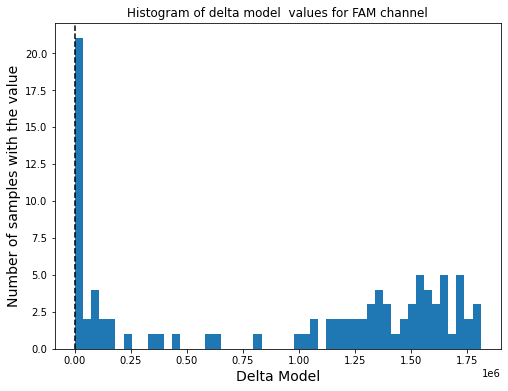

In [8]:

threshold = 2000

plt.figure(figsize=(8,6))
plt.hist(delta_df['model_delta'], bins=50)
plt.xlabel('Delta Model', fontsize=14)
plt.ylabel('Number of samples with the value', fontsize=14)
plt.title('Histogram of delta model  values for FAM channel' )
plt.axvline(threshold, linestyle='--', color='k')
#plt.yscale('log')
plt.show()

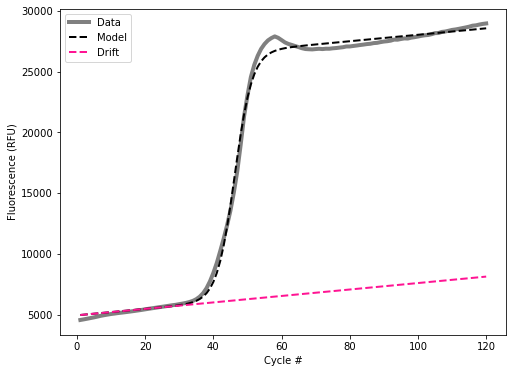

In [7]:
# If you want to plot a well, and its model fit:  
well = 'B8'
fluor = 'FAM'

pa.plot_well_with_fit(well, fluor)
delta = pa.integral_compare(well, fluor)

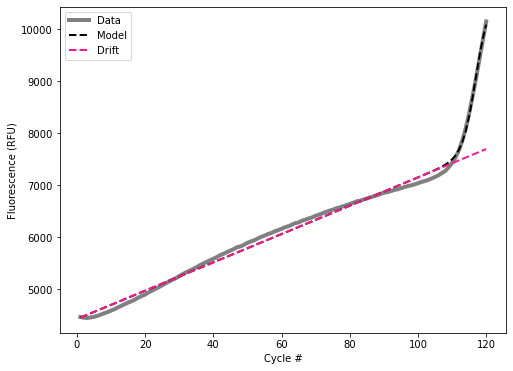

9832.959066321375


In [8]:
# If you want to plot a well, and its model fit:  
well = 'E2'
fluor = 'FAM'

pa.plot_well_with_fit(well, fluor)

delta = pa.integral_compare(well, fluor)
type(delta)
print(delta)

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Import dataset from CSV file
data = pd.read_csv("3B_delta_ROC.csv")

# Define the predictor variables and the response variable
X = data['delta']
y = data['manual']

# Calculates FPR, TPR and threholds required for AUC
preds = data['delta']
y_test = data['manual']
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Generates AUC plot for delta value
display = RocCurveDisplay(
    fpr = fpr, 
    tpr = tpr, 
    roc_auc = roc_auc, 
)

display.plot()
plt.title('Delta vs. manual')
plt.show()

# Generates scatter plot for delta (integrals)
plt.scatter(data['delta'], data['manual'])
plt.axvline(x=threshold[len(threshold)-3], color='r', linestyle='--', linewidth=1)
#plt.text(threshold[len(threshold)-3]-10, 0.2, 'threshold', rotation=90, transform=plt.gca().transAxes)
plt.ylabel('Actual Label')
plt.xlabel('Delta')
plt.title('Delta vs. manual')
## add a vertical line with the value from threshold that is third from last (last two are 0 values)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '3B_delta_ROC.csv'

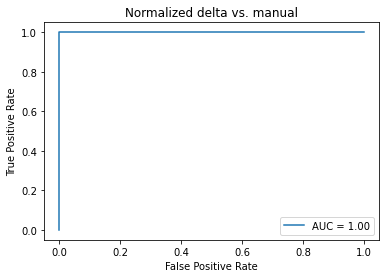

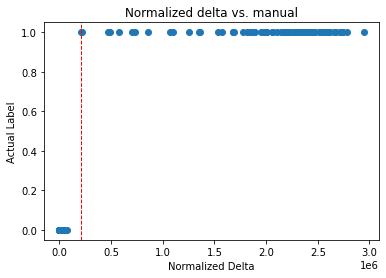

In [52]:
# Calculates FPR, TPR and threholds required for AUC
preds = data['delta_norm']
y_test = data['manual']
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Generates AUC plot for normalized data
display = RocCurveDisplay(
    fpr = fpr, 
    tpr = tpr, 
    roc_auc = roc_auc, 
)

display.plot()
plt.title('Normalized delta vs. manual')
plt.show()

# Generates scatter plot for normalized delta
plt.scatter(data['delta_norm'], data['manual'])
plt.axvline(x=threshold[len(threshold)-3], color='r', linestyle='--', linewidth=1)
plt.ylabel('Actual Label')
plt.xlabel('Normalized Delta')
plt.title('Normalized delta vs. manual')
## add a vertical line with the value from threshold that is third from last (last two are 0 values)
plt.show()